In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

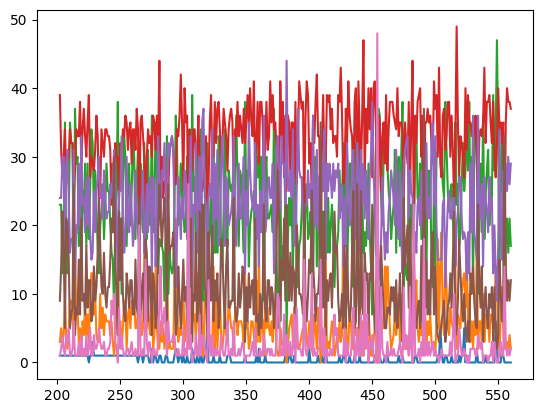

In [27]:
# import raw data and plot
data_set = pd.read_csv('Wordle.csv')
data_x = data_set.loc[:, ['Contest number']].values
data_y = data_set.iloc[:, 5:12].values
plt.plot(data_x, data_y)
plt.show()

In [28]:
data = data_y
data = data.astype('float32')
# print(data)
# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
# data

In [29]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [30]:
reframed = series_to_supervised(data, 1, 1)
values = reframed.values
# Slice the test and training sets.
train_size = int(len(values) * 0.75)
train = values[:train_size, :]
test = values[train_size:, :]
train_x, train_y = train[:, :-7], train[:, -7:]
test_x, test_y = test[:, :-7], test[:, -7:]

# print out their dimensions.
print ('train_x.shape, train_y.shape, test_x.shape, test_y.shape')
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

train_x.shape, train_y.shape, test_x.shape, test_y.shape
(268, 7) (268, 7) (90, 7) (90, 7)


In [31]:
# Initialize paraments.
inp_dim = 7
out_dim = 7
mid_dim = 8
mid_layers = 1
batch_size = 49
mod_dir = '.'

In [32]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)

# Loss function and optimizer.
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [33]:
# Slicing rows in data frame.
var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

batch_var_x = list()
batch_var_y = list()

for i in range(batch_size):
    j = train_size - i
    batch_var_x.append(var_x[j:])
    batch_var_y.append(var_y[j:])

from torch.nn.utils.rnn import pad_sequence

batch_var_x = pad_sequence(batch_var_x)
batch_var_y = pad_sequence(batch_var_y)

with torch.no_grad():
    weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
    weights = torch.tensor(weights, dtype=torch.float32, device=device)

In [34]:
np.shape(batch_var_y)

torch.Size([48, 49, 7])

In [35]:
# Training LSTM model.
net = net.train()
print("Training Start")
for e in range(1000):
    # input data
    out = net(batch_var_x)
    # calculate loss
    loss = criterion(out, batch_var_y)
    loss = loss.mean()
    # optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 64 == 0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
# Save the net locally.
torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
print("Save in:", '{}/net.pth'.format(mod_dir))

Training Start
Epoch:    0, Loss: 0.09341
Epoch:   64, Loss: 0.01158
Epoch:  128, Loss: 0.00919
Epoch:  192, Loss: 0.00721
Epoch:  256, Loss: 0.00588
Epoch:  320, Loss: 0.00491
Epoch:  384, Loss: 0.00397
Epoch:  448, Loss: 0.00339
Epoch:  512, Loss: 0.00303
Epoch:  576, Loss: 0.00278
Epoch:  640, Loss: 0.00262
Epoch:  704, Loss: 0.00251
Epoch:  768, Loss: 0.00243
Epoch:  832, Loss: 0.00235
Epoch:  896, Loss: 0.00229
Epoch:  960, Loss: 0.00222
Save in: ./net.pth


In [36]:
# Read the net data, and start evaluating.
net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
net = net.eval()
# Initial data manually, clear all the test data.
test_x = values[:, :-7]
test_x[train_size:, :] = 0
# prepare for predict 60 days
zeros = np.zeros((60, 7))
test_x = np.concatenate((test_x, zeros), axis=0)

test_x = test_x[:, np.newaxis, :]
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
# Use the net in cycle to predict future data
for i in range(train_size, len(test_x)):
    test_y = net(test_x[:i])
    test_x[i] = test_y[-1]

In [37]:
# Denormalize,and get the prediction results.
# Each row sums to 100
test_x_percent = test_x[:,0,:]
test_x_percent = test_x_percent.cpu().data.numpy()
test_x_percent = scaler.inverse_transform(test_x_percent)
test_x_percent = np.around(test_x_percent)
pred_y = test_x_percent[train_size:]
print(pred_y)
pred_known = pred_y[:len(values)-train_size] # 为测试部分
pred_unknown = pred_y[len(values)-train_size:] # 为预测部分
# Clean the negative data
pred_unknown[pred_unknown<0]=0

[[ 0.  7. 27. ... 22.  6. -1.]
 [ 0.  5. 21. ... 27. 11.  0.]
 [ 0.  8. 28. ... 22.  6. -1.]
 ...
 [-1. -4.  4. ... 41. 23.  4.]
 [-0. -3.  6. ... 30. 18. 11.]
 [ 0.  2. 15. ... 24. 11.  5.]]


Text(0.5, 1.0, 'Prediction of the distribution of the reported results')

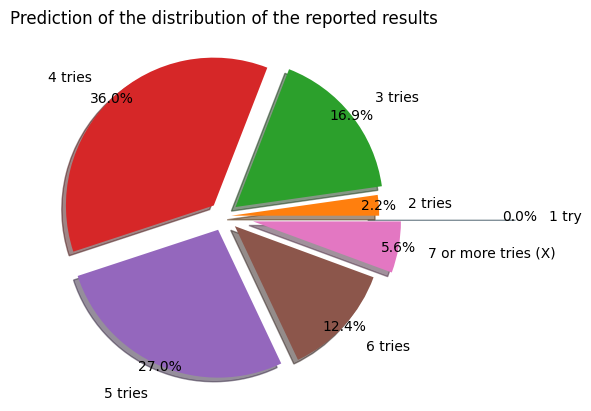

In [66]:
# Label the results and visualizing in a pie.
label=["1 try","2 tries","3 tries","4 tries","5 tries","6 tries","7 or more tries (X)"]
expld=[1,0.05,0.1,0.1,0.1,0.1,0.2]
plt.pie(pred_unknown[59],explode=expld,labels=label, autopct='%3.1f%%',pctdistance = 1,labeldistance = 1.2,shadow=True)
plt.title("Prediction of the distribution of the reported results")